# Machine Learning

In [1]:
import numpy as np
import pandas as pd
import pickle

import sklearn.metrics
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_fscore_support, accuracy_score
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import random

import dgl.function as fn
from dgl import DGLGraph
import dgl.nn.pytorch as dgl_nn
import dgl.transform as dgl_transform

import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

Data_path = 'Data/'

### Creation of Useful Tools

In [2]:
# Plot confusion matrix when classifier not available only confusion matrix
def plot_confusion_matrix(matrix,figure,axes,idx):
    test = axes.matshow(matrix, cmap = newcmp);
    axes.tick_params(axis="x", bottom=True, top=False, labelbottom=True, labeltop=False)
    axes.set_xticklabels(['','Not Nominated','Nominated'],style='italic')
    axes.set_xlabel('Predicted Label')
    if idx == 0: 
        axes.set_yticklabels(['','Not Nominated','Nominated'],style='italic')
        axes.set_ylabel('True Label')
    #figure.colorbar(test, ax=axes)
    for (j,i),label in np.ndenumerate(matrix):
        axes.text(i,j,np.round(label,3),ha='center',va='center',color = 'black')

In [3]:
# Creation of gold colormap
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace( 255/256,184/256, N)
vals[:, 1] = np.linspace( 215/256,134/256, N)
vals[:, 2] = np.linspace( 0/256,11/256, N)

newcmp = ListedColormap(vals)

### Loading the similarity matrix and generate graph

In [4]:
# Load similarity matrix
file = open(Data_path + 'Adjacency_matrix_all025.pickle', 'rb')
adj_mat =  pickle.load(file)

# Generate graph
G = DGLGraph(graph_data=adj_mat)
G = dgl_transform.add_self_loop(G) # we are sure of doing this?

### Loading features and labels

In [5]:
# Features
features_df = pd.read_csv(Data_path + 'features.csv',index_col=0).drop(columns = ['title'])
# Labels
labels_df = pd.read_csv(Data_path + 'labels.csv',index_col=0).drop(columns = ['title', ])
IMDB_nom = labels_df['Nominations'].copy()
IMDB_nom.loc[IMDB_nom > 0] = 1
# Checking class imbalance
IMDB_nom.value_counts() # 18.263 % of CLASS 1

0.0    3728
1.0    1074
Name: Nominations, dtype: int64

### Features engineering

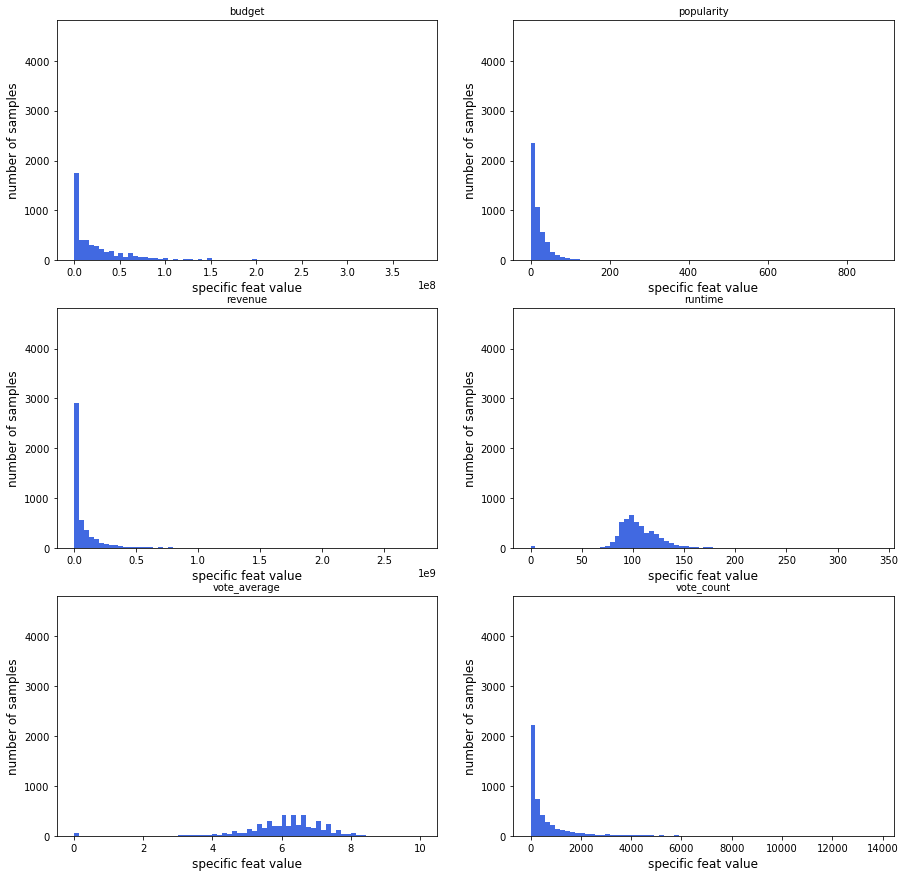

In [6]:
# To visualize features distribution
features_to_plot = features_df[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]
feat_names = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
fig, axs = plt.subplots(3, 2,figsize=(15, 15))
feat_mat = features_to_plot

for name, ax in zip(feat_names, axs.reshape(-1)):
    ax.hist(features_to_plot[name].values, bins=70,color='royalblue')
    ax.set_title(name,size=10)
    ax.set_ylim([0, 4810])
    ax.set_xlabel('specific feat value',size=12)
    ax.set_ylabel('number of samples',size=12)
plt.show()

In [7]:
def feat_transform(x):
    '''
    DESCRIPTION: apply logarithmic function to features to generate unskewed distributions
    INPUT: 
        |--- x: [list] skewed feature distribution
    OUTPUT:
        |--- transformed_x: [list] unskewed feature distribution
    '''
    trasformed_x = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]>0:
            trasformed_x[i] = np.log(x[i]) 
        else:
            trasformed_x[i] = x[i]
    return trasformed_x

In [8]:
# Transformation of budget, popularity, revenue and vote_count features
features_to_transform = features_df[['budget', 'popularity', 'revenue', 'vote_count']]
feat_names = ['budget', 'popularity', 'revenue', 'vote_count']
transformed_feat = features_df.copy()
for name in feat_names:
    transformed_feat[name] = feat_transform(features_to_transform[name])
    

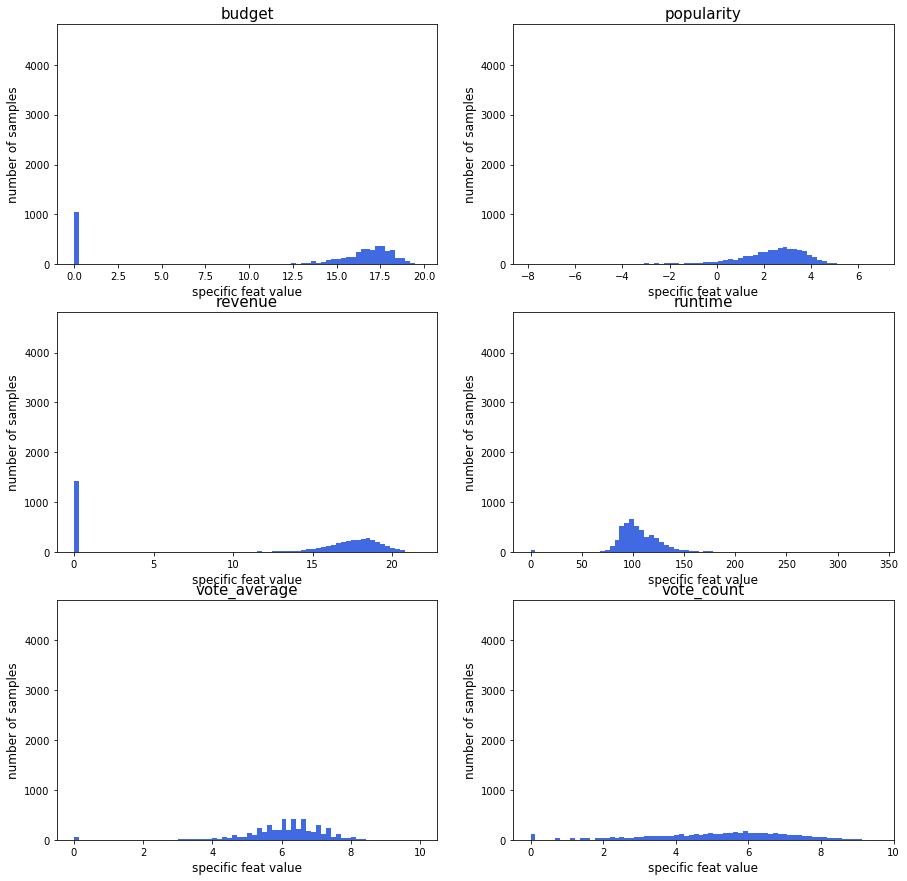

In [9]:
# To visualize features after the transformation
trasformed_features_to_plot = transformed_feat[['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']]
feat_names = ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
fig, axs = plt.subplots(3, 2,figsize=(15, 15))
feat_mat = features_to_plot

for name, ax in zip(feat_names, axs.reshape(-1)):
    ax.hist(trasformed_features_to_plot[name].values, bins=70,color='royalblue')
    ax.set_title(name,size=15)
    ax.set_ylim([0, 4810])
    ax.set_xlabel('specific feat value',size=12)
    ax.set_ylabel('number of samples',size=12)
plt.show()

### Split data and Generate train, val, test masks

In [10]:
# Split
sss1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8) 
sss2 = StratifiedShuffleSplit(n_splits=1, train_size=0.8) 

# Mask generation
for prov_index, test_index in sss1.split(transformed_feat, IMDB_nom.values):
    prov_mask = prov_index
    test_mask = test_index

for train_index, val_index in sss2.split(transformed_feat.iloc[prov_mask], IMDB_nom.values[prov_mask]):
    train_mask = train_index
    val_mask = val_index

### Standardize 

In [11]:
def do_standardisation(data, train_mask):
    '''
    DESCRIPTION: standardise features to zero mean and unit variance
    INPUT: 
        |--- data: [np.darray] feature matrix
        |--- train_mask: [list] indices of train samples
        |--- val_mask: [list] indices of validation samples
        |--- test_mask: [list] indices of test samples
    OUTPUT:
        |--- data: [np.darray] feature matrix with standardized feature columns
    '''
    scaler = StandardScaler()
    scaler.fit(data.iloc[train_mask].to_numpy())
    return pd.DataFrame(data = scaler.transform(data.to_numpy()),columns=data.columns)

In [12]:
# Standardization of feature matrix
transformed_feat_std = do_standardisation(transformed_feat, train_mask)

### Create Tensors

In [13]:
# feature tensors
tensor_data_std = torch.FloatTensor(transformed_feat_std.values)
# labels tensors
tensor_labels = torch.LongTensor(IMDB_nom.values)

## Random Classifier 

In [14]:
def random_classifier(X):
    """
    DESCRIPTION : Binary classification at random
    INPUT
        |--- X (2D numpy array) the input data (the sample dimension is the first one)
    OUTPUT 
        |--- y (1D numpy array) the random prediction for each sample
    """
    return np.random.randint(0, 2, X.shape[0])

In [15]:
def random_classification(data, labels, mask, name, N):
    """
    DESCRIPTION : 
    INPUT
        |--- data: [torch.Floattensor] tensor containing feature matrix
        |--- labels: [torch.LongTensor] tensor containing labels vector
        |--- mask: [list] indices of the group of samples of interest
        |--- name: [string] name of the sample set considered (train, validation, test)
        |--- N: [int] number of trials
    """
    
    precision, recall, f1score, accuracy, CM = [], [], [], [], []
    for _ in range(N):
        rand_pred = random_classifier(data[mask,:])
        pre,rec,f1,sup = precision_recall_fscore_support(labels[mask], rand_pred)
        acc = accuracy_score(labels[mask], rand_pred)
        precision.append(pre[1])
        recall.append(rec[1])
        f1score.append(f1[1])
        accuracy.append(acc)
        CM.append(confusion_matrix(labels[mask], rand_pred))

    print(f'Random Classifier on the {name} set \n'+'-'*80)
    print(f'\t |---- Precision {np.mean(precision):.2%} +/- {np.std(precision):.2%} ')
    print(f'\t |---- Recall {np.mean(recall):.2%} +/- {np.std(recall):.2%}')
    print(f'\t |---- F1-score {np.mean(f1score):.2%} +/- {np.std(f1score):.2%}')
    print(f'\t |---- Accuracy {np.mean(accuracy):.2%} +/- {np.std(accuracy):.2%}')
    print(f'\t \n{np.mean(CM, axis=0)} \n')

In [16]:
N = 50 # generating 50 random classifiers
random_classification(tensor_data_std, tensor_labels, train_mask, 'Train', N) # train set
random_classification(tensor_data_std, tensor_labels, val_mask, 'Validation', N) # validation set
random_classification(tensor_data_std, tensor_labels, test_mask, 'Test', N) # test set

Random Classifier on the Train set 
--------------------------------------------------------------------------------
	 |---- Precision 24.86% +/- 0.91% 
	 |---- Recall 50.03% +/- 1.88%
	 |---- F1-score 33.21% +/- 1.19%
	 |---- Accuracy 49.95% +/- 1.08%
	 
[[1152.32 1155.68]
 [ 381.76  382.24]] 

Random Classifier on the Validation set 
--------------------------------------------------------------------------------
	 |---- Precision 23.36% +/- 1.20% 
	 |---- Recall 50.17% +/- 3.19%
	 |---- F1-score 31.86% +/- 1.69%
	 |---- Accuracy 49.53% +/- 1.56%
	 
[[290.06 297.94]
 [ 90.2   90.8 ]] 

Random Classifier on the Test set 
--------------------------------------------------------------------------------
	 |---- Precision 22.06% +/- 1.53% 
	 |---- Recall 49.44% +/- 4.26%
	 |---- F1-score 30.50% +/- 2.23%
	 |---- Accuracy 49.64% +/- 1.50%
	 
[[370.72 375.28]
 [108.7  106.3 ]] 



### Building Logistic Regression

In [17]:
clf = LogisticRegression(C= 1,random_state = 0,solver = 'lbfgs').fit(transformed_feat_std.iloc[train_mask].to_numpy(),IMDB_nom.values[train_mask])
train_pred = clf.predict(transformed_feat_std.iloc[train_mask].to_numpy())
test_pred = clf.predict(transformed_feat_std.iloc[test_mask].to_numpy())

# Train set results
tr_pre_log,tr_rec_log,tr_f1_log,tr_sup_log = precision_recall_fscore_support(train_pred,IMDB_nom.values[train_mask])
tr_acc_log = sklearn.metrics.accuracy_score(IMDB_nom.values[train_mask], train_pred, normalize=True, sample_weight=None)

print('Training set:')
print('>>> Precision: {:0.4}'.format(tr_pre_log[1]))
print('>>> Recall: {:0.4}'.format(tr_rec_log[1]))
print('>>> F1: {:0.4}'.format(tr_f1_log[1]))
print('>>> Support: {:}'.format(tr_sup_log[1]))
print('')

# Test set results
test_pre_log,test_rec_log,test_f1_log,test_sup_log = precision_recall_fscore_support(test_pred,IMDB_nom.values[test_mask])
test_acc_log = sklearn.metrics.accuracy_score(IMDB_nom.values[test_mask], test_pred, normalize=True, sample_weight=None)

print('Test set:')
print('>>> Precision: {:0.4}'.format(test_pre_log[1]))
print('>>> Recall: {:0.4}'.format(test_rec_log[1]))
print('>>> F1: {:0.4}'.format(test_f1_log[1]))
print('>>> Support: {:}'.format(test_sup_log[1]))

Training set:
>>> Precision: 0.5118
>>> Recall: 0.697
>>> F1: 0.5902
>>> Support: 561

Test set:
>>> Precision: 0.5023
>>> Recall: 0.6923
>>> F1: 0.5822
>>> Support: 156


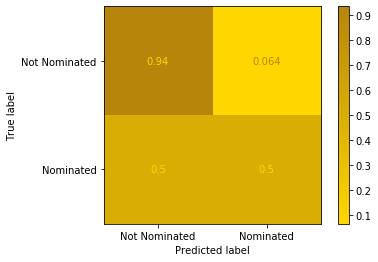

In [35]:
# Confusion Matrix on test set classification
disp = sklearn.metrics.plot_confusion_matrix(clf, transformed_feat_std.iloc[test_mask],IMDB_nom.values[test_mask],cmap=newcmp,display_labels = ['Not Nominated','Nominated'],normalize='true')
C_log = sklearn.metrics.confusion_matrix(IMDB_nom.values[test_mask], test_pred)

### Building Graph Filtering & Logistic Regression 

In [19]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()

        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights) # X*Teta

        result = self.pol_weights[0] * feat.clone() # a0*L^0*X*Teta <-- fisrt polynomial weight a0 * L^0 * x

        for i in range(1, self._k + 1): # get the next polynomial coefficient (a1*L^1, a2*L^2, ..... ak*L^k) 
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h')) # update all nodes with msg function copy_src (get data from source node) and reduce function sum
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [20]:
def train(model, g, features, labels, train_mask, loss_fcn, optimizer):
    """ 
    DESCRIPTION : Train and update model classification performances with training set
    INPUT:
        |--- model: [] classification model to train
        |--- g: [DGLgraph] DeepGraphLearning graph object
        |--- features: [FloatTensor] 2D tensor containing samples' features
        |--- labels: [LongTensor] 1D tensor containing samples' labels (0-1)
        |--- train_mask: [np.array] indices of training set
        |--- loss_fcn: pytorch loss function chosen for model training
        |--- optimizer: pytorch model optimizer 
    OUTPUT:
        |--- loss: [float] value of loss function for the model at current state
    """
    model.train()  
    
    pred = model(g, features)[train_mask] 
    loss = loss_fcn(pred, labels[train_mask])
    _, indices = torch.max(pred, dim=1)
    acc = sklearn.metrics.accuracy_score(labels[train_mask], indices.numpy(), normalize=True, sample_weight=None)
    pre,rec,f1,sup = precision_recall_fscore_support(labels[train_mask],indices.numpy())
    optimizer.zero_grad()    
    loss.backward()

    optimizer.step()

    return loss, pre[1], rec[1], f1[1], sup[1], acc
    
def evaluate(model, g, features, mask, labels):
    """ 
    DESCRIPTION : Evaluate model classification performance on validation set 
    INPUT:
        |--- model: [] classification model to evaluate
        |--- g: [DGLgraph] DeepGraphLearning graph object
        |--- features: [FloatTensor] 2D tensor containing samples' features
        |--- labels: [LongTensor] 1D tensor containing samples' labels (0-1)
        |--- mask: [np.array] indices of validation set
    OUTPUT:
        |--- acc: [float] classification accuracy
        |--- recall: [float] classification recall
        |--- precision: [float] classification precision
        |--- f1: [float] classification f1 score
    """
    model.eval() 
    
    with torch.no_grad():
        pred = model(g, features)[mask]  
        labels = labels[mask]
        _, indices = torch.max(pred, dim=1)
        acc = sklearn.metrics.accuracy_score(labels, indices.numpy(), normalize=True, sample_weight=None)
        pre,rec,f1,sup = precision_recall_fscore_support(labels,indices.numpy())
        C = sklearn.metrics.confusion_matrix(labels, indices.numpy())
        
        return acc, pre[1], rec[1], f1[1], sup[1], C

In [21]:
# Best Model based on F1 score
pol_order = 3 
lr = 0.3 
weight_decay = 5e-05
n_epochs = 400 
p_dropout = 0.2 
n_classes = 2
in_feats=tensor_data_std.shape[1]

true_ratio = 1074/4802 # <-- fraction of Nominations
weights_loss = torch.FloatTensor([true_ratio, 1-true_ratio]) # to rebalance classes

In [22]:
# Training Laplacian Polynomial Graph Filter & Logistic Regression with best hyperparameters
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

loss_fcn = torch.nn.CrossEntropyLoss(weight=weights_loss)
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)

losses_logF = []
f1_val = []
f1_tr = []
for epoch in range(n_epochs):

    loss, pre_tr_logF, rec_tr_logF, f1_tr_logF, sup_tr_logF, acc_tr_logF = train(model, G, tensor_data_std, tensor_labels, train_mask, loss_fcn, optimizer)
    losses_logF.append(loss)
    f1_tr.append(f1_tr_logF)

    acc_val_logF, pre_val_logF, rec_val_logF, f1_val_logF, sup_val, C = evaluate(model, G, tensor_data_std, val_mask, tensor_labels)
    f1_val.append(f1_val_logF)
    if (epoch+1)%50 == 0:
        print("Epoch {:05d} | Train Loss {:.4f} | Val precision {:.4%} | Val recall {:.4%} | Val F1 {:.4%}". format(epoch+1, loss.item(), pre_val_logF, rec_val_logF, f1_val_logF))
                       
print()
print('Test:')
acc_test_logF, pre_test_logF, rec_test_logF, f1_test_logF, sup_test, C_logF = evaluate(model, G, tensor_data_std, test_mask, tensor_labels)
print("Precision {:.4%} | Recall {:.4%} | F1 {:.4%}". format(pre_test_logF, rec_test_logF, f1_test_logF))

Epoch 00050 | Train Loss 0.4997 | Val precision 43.9437% | Val recall 86.1878% | Val F1 58.2090%
Epoch 00100 | Train Loss 0.4874 | Val precision 45.9941% | Val recall 85.6354% | Val F1 59.8456%
Epoch 00150 | Train Loss 0.4888 | Val precision 47.9876% | Val recall 85.6354% | Val F1 61.5079%
Epoch 00200 | Train Loss 0.4888 | Val precision 46.0411% | Val recall 86.7403% | Val F1 60.1533%
Epoch 00250 | Train Loss 0.4949 | Val precision 47.2222% | Val recall 84.5304% | Val F1 60.5941%
Epoch 00300 | Train Loss 0.4802 | Val precision 45.5882% | Val recall 85.6354% | Val F1 59.5010%
Epoch 00350 | Train Loss 0.4950 | Val precision 46.3415% | Val recall 83.9779% | Val F1 59.7250%
Epoch 00400 | Train Loss 0.4846 | Val precision 47.5884% | Val recall 81.7680% | Val F1 60.1626%

Test:
Precision 48.8950% | Recall 82.3256% | F1 61.3518%


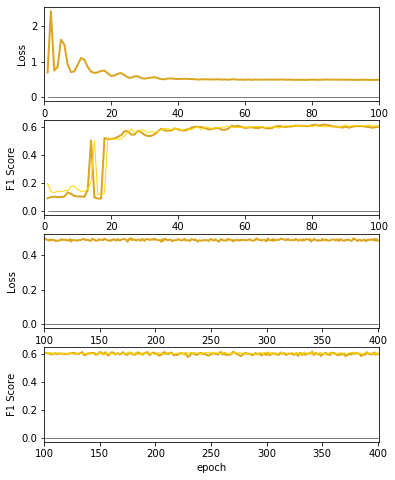

In [23]:
# Plot loss and f1 score across epochs 
fig, axs = plt.subplots(4,1,figsize=(6,8))
ep = np.arange(1,n_epochs+1,1)
axs[0].plot(ep[0:100], losses_logF[0:100], color='Goldenrod', linewidth=2)
axs[0].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[0].set_xlim([0,100])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(ep[0:100], f1_val[0:100], color='Goldenrod', linewidth=2)
axs[1].plot(ep[0:100], f1_tr[0:100], color='Gold', linewidth=1)
axs[1].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[1].set_xlim([0,100])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('F1 Score')

axs[2].plot(ep[100:], losses_logF[100:], color='Goldenrod', linewidth=2)
axs[2].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[2].set_xlim([100,n_epochs+1])
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('Loss')

axs[3].plot(ep[100:], f1_val[100:], color='Goldenrod', linewidth=2)
axs[3].plot(ep[100:], f1_tr[100:], color='Gold', linewidth=1)
axs[3].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[3].set_xlim([100,n_epochs+1])
axs[3].set_xlabel('epoch')
axs[3].set_ylabel('F1 Score')

plt.show()

### Tuning of Laplacian Polynomial

In [ ]:
# Ranges of hyperparameters to test in Grid Search
n_epochs = 1000
learning_rate = [3e-1,5e-1,5e-2,1e-2]
pol_order = [2,3,4] 
p_dropout = [0.2,0.3,0.4] 
weight_decay = [0,5e-5,5e-6]
standard_options = [False, True]

n_classes = 2
in_feats=tensor_data.shape[1]

true_ratio = 1074/4802 # <-- fraction of Nominations
weights_loss = torch.FloatTensor([true_ratio, 1-true_ratio]) # to rebalance

In [ ]:
def grid_search_LP(learning_rate, pol_order,p_dropout,weight_decay):
    
    performances = torch.zeros(len(learning_rate),len(pol_order),len(p_dropout),len(weight_decay),len(standard_options))
    for l, lr_ in enumerate(learning_rate):
        for p, p_order in enumerate(pol_order):
            for d, dropout in enumerate(p_dropout):
                for w, weight in enumerate(weight_decay):
                    for s, standard in enumerate(standard_options):
                        
                        if standard: 
                            features = do_standardisation(transformed_feat_std,train_mask,val_mask,test_mask)
                            tensor_data_std = torch.FloatTensor(features.values)
                        else: 
                            tensor_data_std = tensor_data
                        
                        model = LaplacianPolynomial(in_feats, n_classes, p_order, dropout)

                        loss_fcn = torch.nn.CrossEntropyLoss(weight=weights_loss)
                        optimizer = torch.optim.Adam(model.parameters(),lr=lr_, weight_decay = weight)
                        losses_tr = []

                        for epoch in range(n_epochs):
                            loss = train(model, G, tensor_data_std, tensor_labels, train_mask, loss_fcn, optimizer)
                            losses_tr.append(loss.item())
                            acc, pre, rec, f1, sup, C = evaluate(model, G, tensor_data_std, val_mask, tensor_labels) 
                            performances[l,p,d,w,s] = f1
                            if (epoch+1)%100 == 0:
                                print("Epoch {:05d} | Train Loss {:.4f} | Val precision {:.4%} | Val recall {:.4%} | Val F1 {:.4%}". format(epoch+1, loss.item(), pre, rec, f1))
                            

    best_performance = torch.max(performances)
    best_idx = (performances == best_performance).nonzero();

    best_lr = learning_rate[best_idx[0,0]]
    best_p_order = pol_order[best_idx[0,1]]
    best_dropout = p_dropout[best_idx[0,2]]
    best_weight = weight_decay[best_idx[0,3]]
    best_standard = standard_options[best_idx[0,4]]
                
    results = [best_performance, best_lr,  best_p_order, best_dropout,best_weight, best_standard]
    return results

In [ ]:
# Perform Grid Search
results_LP = grid_search_LP(learning_rate, pol_order,p_dropout,weight_decay)
print(results_LP)

In [24]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ 
        DESCRIPTION : Compute response of filtering using a polynomial filter 
        INPUT:
            |--- coeff: [np.array] coeffiicients of polynomial filter
            |--- lam: [np.ndarray] eigenvalues 
        OUTPUT:
            |--- response: [np.ndarray] response[i] is the spectral response at frequency lam[i]
    """
    V = np.vander(lam,coeff.shape[0],increasing=True)
    response = V@coeff
    return response

In [25]:
def spectral_decomposition(laplacian: np.ndarray):
    """ 
        DESCRIPTION : Compute spectral decomposition of a graph using the graph Laplacian
        INPUT:
            |--- laplacian: [np.ndarray] graph laplacian 
        OUTPUT:
            |--- lamb: [np.ndarray] containing graph eigenvalues
            |--- U: [np.ndarray] containing corresponding graph eigenvectors
    """
    # compute the eigenvalues and eigenvectors
    if np.allclose(laplacian, laplacian.T, 1e-12):
        lamb, U = np.linalg.eigh(laplacian)
    else:
        lamb, U = np.linalg.eig(laplacian)
        #sort them
        idx = np.argsort(lamb, axis=0)
        lamb = lamb[idx]
        U = U[:,idx]
    
    return lamb, U

In [26]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ 
        DESCRIPTION : Compute spectral decomposition of a graph using the graph Laplacian
        INPUT:
            |--- adjacency: [np.ndarray] adjacency matrix of the graph
            |--- normalize: [bool] if normalize laplacian or not
        OUTPUT:
            |--- L: [n x n ndarray] combinatorial or symmetric normalized Laplacian. of the graph 
    """
    # degrees
    I = np.identity(adjacency.shape[0])
    degree = np.sum(adjacency, axis=1)
    # Compute laplacian
    D = I.copy()
    np.fill_diagonal(D, degree)
    L = D - adjacency
    # normalized if requested 
    if normalize:
        D12 = np.where(D > 0, np.power(D, -0.5, where=D>0), 0)
        L = D12 @ L @ D12
        
    return L

In [27]:
L_norm = compute_laplacian(adjacency =adj_mat, normalize = True)
lamb_, _ = spectral_decomposition(laplacian = L_norm)

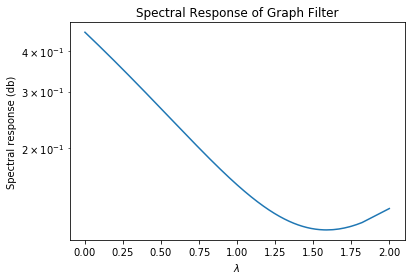

In [28]:
# Plot Final Spectral response of Polynomial Filter
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(lamb_,np.abs(polynomial_graph_filter_response(model.pol_weights.detach().numpy(), lamb_)))
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Spectral response (db)')
ax.set_title('Spectral Response of Graph Filter')
plt.show()

### Building Graph Neural Network

In [29]:
class Linear_GNN(nn.Module):
    def __init__(self, in_feats: int, out_feats: int, first_layer_size: int, hidden_size: int):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._first_layer_size = first_layer_size
        self._hidden_size = hidden_size

        layer_size = 128
        self.linear = nn.Linear(self._in_feats, self._first_layer_size)
        self.gcn1 = dgl_nn.conv.GraphConv(self._first_layer_size, layer_size, activation=F.relu)
        self.gcn2 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn3 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn4 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn5 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn6 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn7 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn8 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn9 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn10 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.gcn11 = dgl_nn.conv.GraphConv(layer_size, layer_size, activation=F.relu)
        self.linear1 = nn.Linear(layer_size, self._hidden_size)
        self.linear2 = nn.Linear(self._hidden_size, self._out_feats)
        
    def forward(self, graph, feat):
        h = F.relu(self.linear(feat))
        h = self.gcn1(graph, h)
        h = self.gcn2(graph, h)
        h = self.gcn3(graph, h)
        h = self.gcn4(graph, h)
        h = self.gcn5(graph, h)
        h = self.gcn6(graph, h)
        h = self.gcn7(graph, h)
        h = self.gcn8(graph, h)
        h = self.gcn9(graph, h)
        h = self.gcn10(graph, h)
        h = self.gcn11(graph, h)
        h = self.linear1(h)
        h = F.relu(h)
        h = self.linear2(h)
        h = F.log_softmax(h, dim=1)
        return h 

In [30]:
# Best Model based on F1 score 
in_feats = tensor_data_std.shape[1]
out_feats = 2
n_epochs = 1000
learning_rate = 1e-3
first_layer_size = 16
hidden_size = 512
weight_decay = 0 
true_ratio = 1074/4802 # <-- fraction of Nominations
weights_loss = torch.FloatTensor([true_ratio, 1-true_ratio]) # to rebalance classes

In [31]:
# Training Linear GNN model with best hyperparameters
model = Linear_GNN(in_feats, out_feats, first_layer_size, hidden_size)

loss_fcn = torch.nn.CrossEntropyLoss(weight=weights_loss)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=weight_decay)
losses_tr_GNN = []

for epoch in range(n_epochs):
    
    loss, pre_tr_GNN, rec_tr_GNN, f1_tr_GNN, sup_tr_GNN, acc_tr_GNN = train(model, G, tensor_data_std, tensor_labels, train_mask, loss_fcn, optimizer)
    losses_tr_GNN.append(loss.item())
    acc_val_GNN, pre_val_GNN, rec_val_GNN, f1_val_GNN, sup_val_GNN, C = evaluate(model, G, tensor_data_std, val_mask, tensor_labels)
    if (epoch+1)%50 == 0:
        print("Epoch {:05d} | Train Loss {:.4f} | Val precision {:.4%} | Val recall {:.4%} | Val F1 {:.4%}". format(epoch+1, loss.item(), pre_val_GNN, rec_val_GNN, f1_val_GNN))

print()
print('Test:')
acc_test_GNN, pre_test_GNN, rec_test_GNN, f1_test_GNN, sup_test_GNN, C_GNN = evaluate(model, G, tensor_data_std, test_mask, tensor_labels)
print("Precision {:.4%} | Recall {:.4%} | F1 {:.4%}". format(pre_test_GNN, rec_test_GNN, f1_test_GNN))

/Users/alicebizeul/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 00050 | Train Loss 0.6045 | Val precision 35.2357% | Val recall 78.4530% | Val F1 48.6301%
Epoch 00100 | Train Loss 0.5917 | Val precision 32.7004% | Val recall 85.6354% | Val F1 47.3282%
Epoch 00150 | Train Loss 0.5844 | Val precision 35.3365% | Val recall 81.2155% | Val F1 49.2462%
Epoch 00200 | Train Loss 0.5813 | Val precision 35.9223% | Val recall 81.7680% | Val F1 49.9157%
Epoch 00250 | Train Loss 0.5755 | Val precision 37.6316% | Val recall 79.0055% | Val F1 50.9804%
Epoch 00300 | Train Loss 0.5764 | Val precision 34.8235% | Val recall 81.7680% | Val F1 48.8449%
Epoch 00350 | Train Loss 0.5708 | Val precision 38.0697% | Val recall 78.4530% | Val F1 51.2635%
Epoch 00400 | Train Loss 0.5729 | Val precision 41.6928% | Val recall 73.4807% | Val F1 53.2000%
Epoch 00450 | Train Loss 0.5688 | Val precision 38.1579% | Val recall 80.1105% | Val F1 51.6934%
Epoch 00500 | Train Loss 0.5618 | Val precision 39.3586% | Val recall 74.5856% | Val F1 51.5267%
Epoch 00550 | Train Loss 0.554

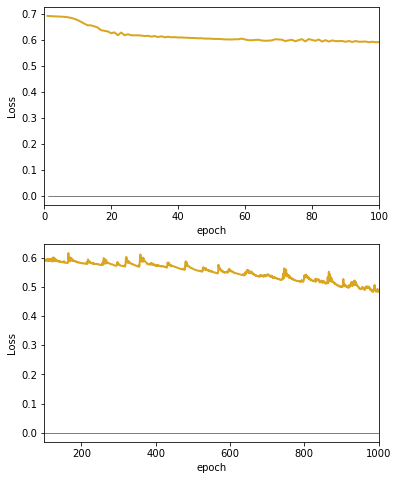

In [40]:
# Plot loss and f1 score across epochs 
fig, axs = plt.subplots(2,1,figsize=(6,8))
ep = np.arange(1,n_epochs+1,1)
axs[0].plot(ep[0:100], losses_tr_GNN[0:100], color='Goldenrod', linewidth=2)
axs[0].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[0].set_xlim([0,100])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('Loss')

axs[1].plot(ep[100:], losses_tr_GNN[100:], color='Goldenrod', linewidth=2)
axs[1].plot(ep, np.zeros(ep.shape), color='black', linewidth=0.5)
axs[1].set_xlim([100,n_epochs+1])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('Loss')

plt.show()

### Tuning Graph NN 

In [ ]:
# Ranges of hyperparameters to test in Grid Search
in_feats = tensor_data.shape[1]
out_feats = 2
k = 11 
n_epochs = 800
learning_rate = [1e-2,1e-3]
first_layer_size = [4,8,16]
hidden_size = [256,512]
weight_decay = [0,5e-5] 


In [ ]:
def grid_search_NN(learning_rate, first_layer_size,hidden_size,weight_decay):
    
    performances = torch.zeros(len(learning_rate),len(first_layer_size),len(hidden_size),len(weight_decay))
    for l, lr_ in enumerate(learning_rate):
        for f, f_layer in enumerate(first_layer_size):
            for h, hidden in enumerate(hidden_size):
                for w, weight in enumerate(weight_decay):
                        
                    model = Linear_GNN(in_feats, out_feats, f_layer, hidden)

                    loss_fcn = torch.nn.CrossEntropyLoss(weight=weights_loss)
                    optimizer = torch.optim.Adam(model.parameters(),lr=lr_, weight_decay=weight)
                    losses_tr = []

                    for epoch in range(n_epochs):
                        loss, pre, rec, f1, sup, acc = train(model, G, tensor_data, tensor_labels, train_mask, loss_fcn, optimizer)
                        losses_tr.append(loss.item())
                        acc,pre, rec, f1, sup, C = evaluate(model, G, tensor_data, val_mask, tensor_labels) 
                        performances[l,f,h,w] = f1
                        if (epoch+1)%100 == 0:
                                print("Epoch {:05d} | Train Loss {:.4f} | Val precision {:.4%} | Val recall {:.4%} | Val F1 {:.4%}". format(epoch+1, loss.item(), pre, rec, f1))
                            

    best_performance = torch.max(performances)
    best_idx = (performances == best_performance).nonzero();

    best_lr = learning_rate[best_idx[0,0]]
    best_first_layer = first_layer_size[best_idx[0,1]]
    best_hidden_layer = hidden_size[best_idx[0,2]]
    best_weight = weight_decay[best_idx[0,3]]
                
    results = [best_performance, best_lr, best_first_layer, best_hidden_layer,best_weight]
    return results

In [ ]:
# Perform Grid Search
results_NN = grid_search_NN(learning_rate, first_layer_size,hidden_size,weight_decay)
print(results_NN)


### Plot Final Results

In [36]:
# Concatenating Results
train_log = (tr_acc_log,tr_rec_log[1],tr_f1_log[1],tr_pre_log[1])
test_log = (test_acc_log,test_rec_log[1],test_f1_log[1],test_pre_log[1])
train_logF = (acc_tr_logF,rec_tr_logF, f1_tr_logF,pre_tr_logF)
test_logF = (acc_test_logF,rec_test_logF, f1_test_logF,pre_tr_logF)
train_GNN = (acc_tr_GNN,rec_tr_GNN, f1_tr_GNN,pre_tr_GNN)
test_GNN = (acc_test_GNN,rec_test_GNN, f1_test_GNN,pre_test_GNN)
train_rn = (0.5,0.4961,0.3316,0.2491)
test_rn = (0.5036,0.5007,0.3108,0.2254)


In [37]:
ind = np.arange(4)  # the x locations for the groups
width = 0.35        # the width of the bars

In [38]:
def autolabel(bars, axis, xpos='center'):
    '''
    DESCRIPTION: Add numerical height of each bar of bar plot
    INPUT:
        |--- bars: bar objects from matplotlib bar plot
        |--- axis: [matplotlib.pyplot.Axis] axes on which to add annotations
        |--- xpos: [string] position of the tag of the bar
    '''
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0, 'right': 1, 'left': -1}

    for bar in bars:
        height = bar.get_height()
        axis.annotate('{:0.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(offset[xpos]*3, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha=ha[xpos], va='bottom')

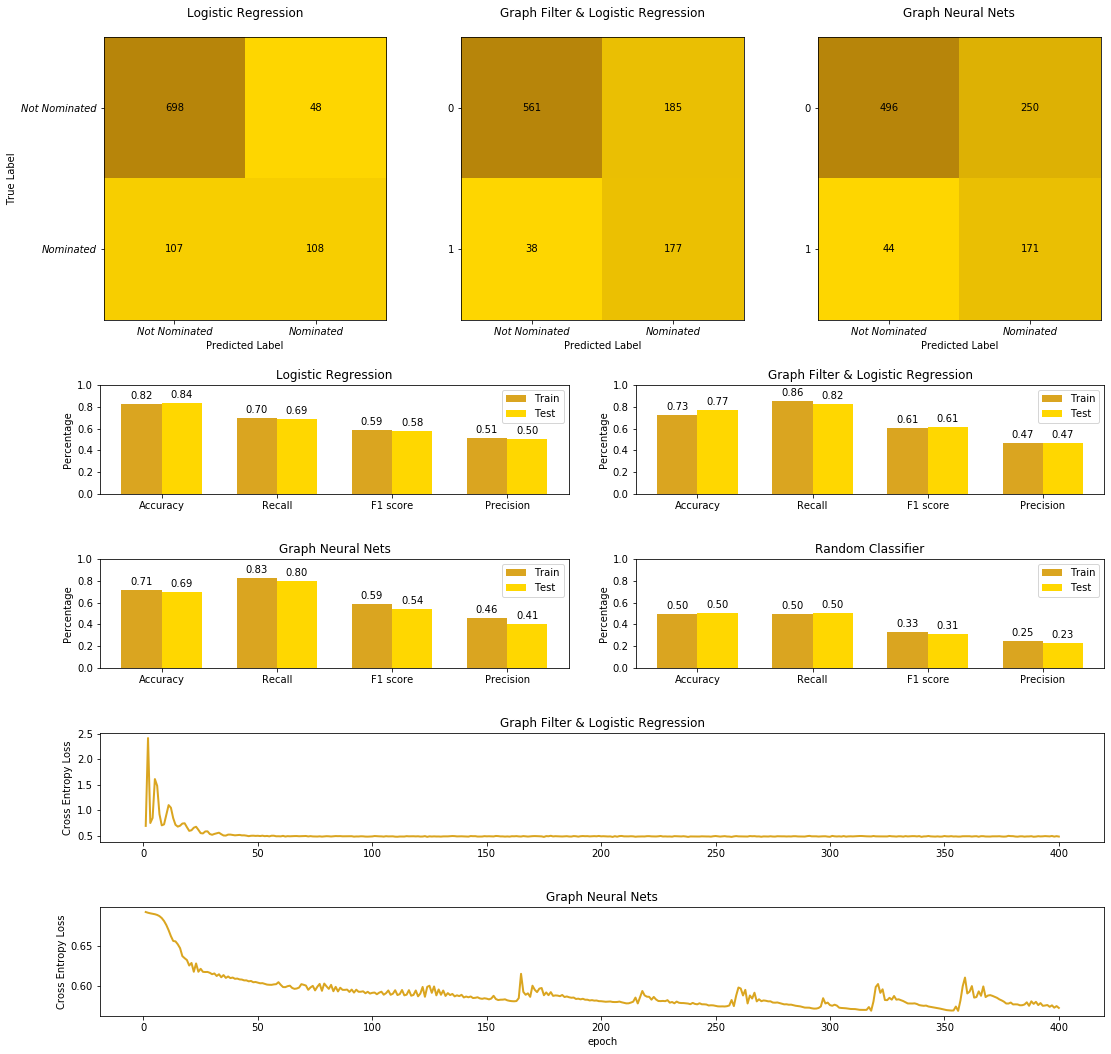

In [39]:
# Plot Evolution across epochs, final performances, confusion matrix
fig = plt.figure(figsize=(18, 18))
gs = plt.GridSpec(6,6, wspace=0.6, hspace=0.6, height_ratios=[0.15,0.15,0.15,0.15,0.15,0.15], width_ratios=[0.15,0.15,0.15,0.15,0.15,0.15])
title_fs = 12

# C1
ax_C1 = fig.add_subplot(gs[0:2,0:2])
plot_confusion_matrix(C_log,fig,ax_C1,0)
ax_C1.set_title('Logistic Regression')

#C2
ax_C2 = fig.add_subplot(gs[0:2,2:4])
plot_confusion_matrix(C_logF,fig,ax_C2,1)
ax_C2.set_title('Graph Filter & Logistic Regression')

#C3
ax_C3 = fig.add_subplot(gs[0:2,4:6])
plot_confusion_matrix(C_GNN,fig,ax_C3,2)
ax_C3.set_title('Graph Neural Nets')

# Barplot 1
ax_bar1 = fig.add_subplot(gs[2,0:3])
bar1 = ax_bar1.bar(list(ind - width/2), train_log, width,label='Train',color = 'Goldenrod')
bar2 = ax_bar1.bar(ind + width/2, test_log, width,label='Test',color = 'Gold')
ax_bar1.set_title('Logistic Regression')
ax_bar1.set_ylabel('Percentage')
ax_bar1.set_ylim(0,1)
ax_bar1.set_xticks(ind)
ax_bar1.set_xticklabels(('Accuracy','Recall','F1 score','Precision'))
ax_bar1.legend()
autolabel(bar1,ax_bar1)
autolabel(bar2,ax_bar1)

# Barplot 2
ax_bar2 = fig.add_subplot(gs[2,3:6])
bar1 = ax_bar2.bar(list(ind - width/2), train_logF, width,label='Train',color = 'Goldenrod')
bar2 = ax_bar2.bar(ind + width/2, test_logF, width,label='Test',color = 'Gold')
ax_bar2.set_title('Graph Filter & Logistic Regression')
ax_bar2.set_ylabel('Percentage')
ax_bar2.set_ylim(0,1)
ax_bar2.set_xticks(ind)
ax_bar2.set_xticklabels(('Accuracy','Recall','F1 score','Precision'))
ax_bar2.legend()
autolabel(bar1,ax_bar2)
autolabel(bar2,ax_bar2)

# Barplot 3
ax_bar3 = fig.add_subplot(gs[3,0:3])
bar1 = ax_bar3.bar(list(ind - width/2), train_GNN, width,label='Train',color = 'Goldenrod')
bar2 = ax_bar3.bar(ind + width/2, test_GNN, width,label='Test',color = 'Gold')
ax_bar3.set_title('Graph Neural Nets')
ax_bar3.set_ylabel('Percentage')
ax_bar3.set_ylim(0,1)
ax_bar3.set_xticks(ind)
ax_bar3.set_xticklabels(('Accuracy','Recall','F1 score','Precision'))
ax_bar3.legend()
autolabel(bar1,ax_bar3)
autolabel(bar2,ax_bar3)

# Barplot 4
ax_bar4 = fig.add_subplot(gs[3,3:6])
bar1 = ax_bar4.bar(list(ind - width/2), train_rn, width,label='Train',color = 'Goldenrod')
bar2 = ax_bar4.bar(ind + width/2, test_rn, width,label='Test',color = 'Gold')
ax_bar4.set_title('Random Classifier')
ax_bar4.set_ylabel('Percentage')
ax_bar4.set_ylim(0,1)
ax_bar4.set_xticks(ind)
ax_bar4.set_xticklabels(('Accuracy','Recall','F1 score','Precision'))
ax_bar4.legend()
autolabel(bar1,ax_bar4)
autolabel(bar2,ax_bar4)

# Epochs 1
ax_epochs1 = fig.add_subplot(gs[4,:])
ep = np.arange(1,400+1,1)
ax_epochs1.plot(ep, losses_logF, color='Goldenrod', linewidth=2)
ax_epochs1.set_title('Graph Filter & Logistic Regression')
ax_epochs1.set_ylabel('Cross Entropy Loss')

# Epochs 2
ax_epochs2 = fig.add_subplot(gs[5,:])
ep = np.arange(1,1000+1,1)
ax_epochs2.plot(ep[:400], losses_tr_GNN[:400], color='Goldenrod', linewidth=2)
ax_epochs2.set_title('Graph Neural Nets')
ax_epochs2.set_xlabel('epoch')
ax_epochs2.set_ylabel('Cross Entropy Loss')

fig.savefig('Figures/results2.png',bbox_inches='tight')
plt.show()
